In [5]:
#!pip install albumentations
#!pip install imgaug

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm 
import time
import os
from PIL import Image
import cv2 
import re

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
#from albumentations.augmentations.transforms import HorizontalFlip,VerticalFlip

%matplotlib inline

## Masha's dataloader

In [3]:
class TwinPairsDataset(Dataset):
    def __init__(self, dataroot, df_pairs, df_views, transform, keypoints=False):
        '''
        dataroot: path to folder with items
        df_pairs: pd dataframe containing pairs of ids and a correspodind label:
                    'Same', 'Fraternal', 'Identical', 'UnknownTwinType',
                    'IdenticalMirror', 'Sibling', 'IdenticalTriplet'
        df_views: pd dataframe containing list of available for each id in the dataset                    
        transform: torchvision transform
        '''
        self.dataroot = dataroot
        self.df_pairs = df_pairs
        self.df_views = df_views
        self.transform = transform
        self.keypoints = keypoints
        
    def __getitem__(self, index):
        sample={}
        
        id_1, id_2  = self.df_pairs.iloc[index][['id_1', 'id_2']].values
        #print(id_1, id_2)
        id_1 = str(id_1)
        id_2 = str(id_2)
        label = int(self.df_pairs.iloc[index].label=='Same')
        #print('Same' if label==1 else 'Twin')
        if id_1==id_2:
             view_1, view_2 = np.random.choice(self.df_views.loc[id_1]['filename'], size=2, replace=False) 
        else:
            view_1 = np.random.choice(self.df_views.loc[id_1]['filename'])
            view_2 = np.random.choice(self.df_views.loc[id_2]['filename'])

        path_1 = os.path.join(self.dataroot, id_1, view_1)
        path_2 = os.path.join(self.dataroot, id_2, view_2)
        
        img_1 = Image.open(path_1)
        img_2 = Image.open(path_2)
        print(view_1)
        print(view_2)
        if self.keypoints:
            df_keypoints=pd.read_csv(self.dataroot+'/df/aligned_landmarks.csv')
            df_flip_keypoints=pd.read_csv(self.dataroot+'/df/aligned_FLIP_landmarks.csv')
            
            if id_1==id_2:
                keypoints_1 = df_keypoints[view_1].values
                keypoints_1=np.array([ [int(t[1:-1].split(', ')[0]),int(t[1:-1].split(', ')[1])] for t in keypoints_1])
                keypoints_2 = df_flip_keypoints[view_2].values
                keypoints_2=np.array([ [int(t[1:-1].split(', ')[0]),int(t[1:-1].split(', ')[1])] for t in keypoints_2])
                
            else:
                keypoints_1 = df_keypoints[view_1].values
                keypoints_2 = df_keypoints[view_2].values
                keypoints_1=np.array([ [int(t[1:-1].split(', ')[0]),int(t[1:-1].split(', ')[1])] for t in keypoints_1])
                keypoints_2=np.array([ [int(t[1:-1].split(', ')[0]),int(t[1:-1].split(', ')[1])] for t in keypoints_2])
            sample['keypoints_1'] = keypoints_1
            sample['keypoints_2'] = keypoints_2
        
        if label==1:
            img_1 = self.transform['twin'](img_1)
            img_2 = self.transform['same'](img_2)
        else:
            img_1 = self.transform['twin'](img_1)
            img_2 = self.transform['twin'](img_2)
            
        sample['img_1']=img_1
        sample['img_2']=img_2
        sample['label']=label
        
        return sample
    
    def __len__(self):
        return self.df_pairs.shape[0]

In [4]:
data_transform ={
    'same': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.RandomHorizontalFlip(p=1),
            
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    'twin': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
                }

In [6]:
views = pd.read_csv('/home/khurram/DL_skoltech/Skoltech_DL_2019/Project/Twins/twins_aligned_cropped_resized/df/views.csv', index_col=0)
views.index = views.index.astype(str)
views.filename = views.filename.apply(eval)

# pairs including 50% of same identities
pairs = pd.read_csv('/home/khurram/DL_skoltech/Skoltech_DL_2019/Project/Twins/twins_aligned_cropped_resized/df/pairs.csv')

direct='/home/khurram/DL_skoltech/Skoltech_DL_2019/Project/Twins/twins_aligned_cropped_resized/'

In [7]:
dataset = TwinPairsDataset(direct, pairs, views,transform=data_transform, keypoints=True)

90354d14.jpg
90354d9.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


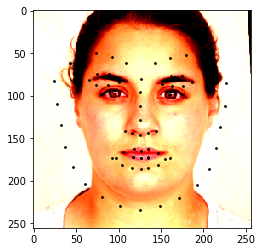

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


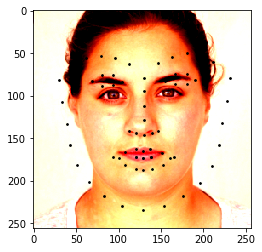

In [8]:
idx = 119

sample = dataset[idx]
std=sample['img_1'].numpy().std()
mean=sample['img_1'].numpy().mean()
plt.imshow(sample['img_1'].numpy().transpose(1,2,0)*std+mean)
kp = sample['keypoints_1']
plt.scatter(kp[:,0], kp[:,1], s=3,color='black')
plt.show()

std=sample['img_2'].numpy().std()
mean=sample['img_2'].numpy().mean()
plt.imshow(sample['img_2'].numpy().transpose(1,2,0)*std+mean)
kp = sample['keypoints_2']
plt.scatter(kp[:,0], kp[:,1], s=3,color='black')

#kp = sample['keypoints_1']
#plt.scatter(kp[:,0], kp[:,1], s=3,color='green')
#plt.show()

In [53]:
kp[0][1:-1]

'25, 108'

In [220]:
kp1=np.round(sample['keypoints_1'])
kp2=np.round(sample['keypoints_2'])


In [235]:
matrix=np.zeros((512,512))

for i in range(kp1.shape[0]):
    #print(int(kp1[i,0]))
    #print(int(kp1[i,1]))
    matrix[int(kp1[i,0]),int(kp1[i,1])]=1
    
for i in range(kp1.shape[0]):
    for j in range()

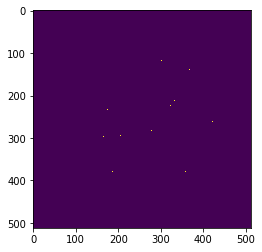

In [236]:
plt.imshow(matrix)

In [185]:
views = pd.read_csv('./twins_aligned_cropped_resized/df/views.csv', index_col=0)
views.index = views.index.astype(str)
views.filename = views.filename.apply(eval)

# pairs including 50% of same identities
pairs = pd.read_csv('./pairs_test.csv')

direct='./twins_aligned_cropped_resized/'
dataset = TwinPairsDataset(direct, pairs, views,transform=data_transform, keypoints=True)

In [179]:
t=0
print(pairs.shape)
for i,sample in enumerate(dataset):
    t+=1
print(t)

(208, 4)
208


### End Masha's  dataloader

In [96]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Load and define the model

In [20]:
from model import MobileFaceNet

model = MobileFaceNet(embedding_size=512)

PATH = os.path.join(os.getcwd(),"./model_mobilefacenet.pth")

checkpoint = torch.load(PATH,map_location=device)

model.load_state_dict(checkpoint)

In [21]:

class ModelBottom(nn.Module):
    def __init__(self, original_model):
        super(ModelBottom, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-2])
        
    def forward(self, x):
        output = self.features(x)
        return output

#define model and fix hidden features size
model_flatten = ModelBottom(model)
outputs = model_flatten(T['img_a'])
hid_size=outputs.data.shape[1]

#define n_classes
classes=os.listdir(direct)
n_classes=len(classes)

#define classifier
model_flatten_classifier = nn.Sequential(
                      nn.Linear(hid_size, 256),
                      nn.ReLU(), 
                      nn.Dropout(0.3),
                      nn.Linear(256, n_classes),                   
                      nn.LogSoftmax(dim=1))

# concatenate conv MobileFaceNet and classifier
class FinModel(nn.Module):
    def __init__(self,flatten_model,classifier_model):
        super(FinModel, self).__init__()
        self.to_flat_model=flatten_model
        self.classifier_model=classifier_model
    def forward(self,x):
        outputs=self.to_flat_model(x)
        outputs=self.classifier_model(outputs)
        return outputs

In [22]:
from sklearn.preprocessing import LabelEncoder,LabelBinarizer

le=LabelEncoder()
lb=LabelBinarizer()
classes=os.listdir(direct)
le.fit(classes)
lb.fit(classes)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [23]:
def accuracy(y_true,y_pred):
    

SyntaxError: unexpected EOF while parsing (<ipython-input-23-676e522ecdee>, line 2)

In [ ]:
def train(model, dataloader,optimizer,criterion,device,n_epochs=5):
    model.to(device)
    model.train()
    
    loss_hist=[]
    for epoch in range(n_epochs):
        loss_epoch=0
        optimizer.zero_grad()
        for _,T in enumerate(dataloader):
            
            classes=T['class_a']
            inputs=T['img_a']

            inputs=inputs.to(device)
            out=torch.Tensor(lb.transform(classes)).to(device)

            y=model(inputs)

            loss=criterion(y,out)
            
            loss_epoch+=loss.detach().numpy()
            
            loss.backward()
            
            optimizer.step()
            
            #print(loss_epoch)
        loss_hist.append(loss_epoch)
        plt.plot(loss_hist,label='loss')
        plt.legend()
        plt.show()
    model.eval()
    

In [ ]:
fmodel=FinModel(model_flatten,model_flatten_classifier)
optimizer = optim.Adam(fmodel.parameters(),lr=0.01)
criterion=nn.MSELoss()


train(fmodel,dataset,optimizer,criterion,device,n_epochs=5)

## Validation

In [5]:
class TwinsDataloaderVal(Dataset):
    def __init__(self, dataroot, df_img, df_relations, transform):
        '''
        dataroot: path to folder with items
        df: pandas dataframe matadata(hasn't been changed)
        df_relatinos: pandas dataframe with relations between classes
        transform: torchvision transform for  images  (transforms.Compose)
        '''
        self.dataroot = dataroot
        self.df = df[df[' yaw']==0]
        self.transform = transform
        self.relations=df_relations
    def __getitem__(self, index):
        
        def get_img_path(img_id):
            return self.dataroot+f'{img_id[:5]}/{img_id[:-4]}__face.jpg'
        
        monetochka=np.random.randint(0,2)
        #print(monetochka)
        id_a = self.df['filename'].iloc[index]
        img_a = Image.open(get_img_path(id_a))
        
        if monetochka==0: 
            find_id=self.relations['subject_id1'].str.find(id_a[:5])
            #print(find_id[find_id!=-1].index.tolist())
            if find_id[find_id!=-1].index.tolist():               
                id_b=self.relations['subject_id2'].iloc[find_id[find_id!=-1].index].values
                relation=self.relations['relationship_type'].iloc[find_id[find_id!=-1].index].values


                if relation[0] in ['Fraternal','Identical','IdenticalMirror','IdenticalTriplet']:
                    flag='Twins'
                    find_id=self.df['filename'].str.find(str(id_b[0][4:]))
                    id_b=self.df['filename'].loc[find_id[find_id!=-1].index[np.random.randint(0,len(find_id[find_id!=-1].index))]]
                    img_b = Image.open(get_img_path(id_b))
                    img_b=self.transform(img_b)
                else:
                    id_b=id_a
                    img_b=img_a.copy()
                    img_b=self.transform(img_b)
                    flag='Not Twins'
            else:
                id_b=id_a
                img_b=img_a.copy()
                img_b=self.transform(img_b)
                flag='Not Twins'
        else:
            id_b=id_a
            img_b=img_a.copy()
            img_b=self.transform(img_b)
            flag='Not Twins'
    
        img_a = self.transform(img_a)

        id_a=id_a[:5]
        id_b=id_b[:5]
        return img_a, img_b,flag

    def __len__(self):
        return self.df.shape[0]

In [11]:
data_transform = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

twins_dataset = TwinsDataloaderVal(direct, df,df_relation ,data_transform)
dataset = DataLoader(twins_dataset, batch_size=10,shuffle=True)

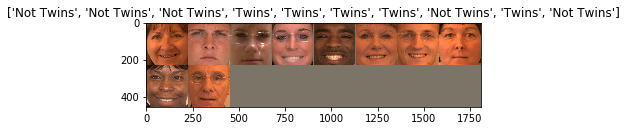

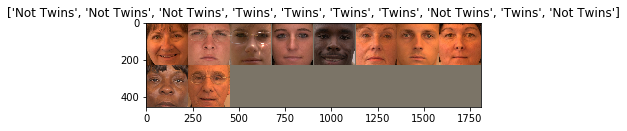

In [12]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
img_a,img_b,label = next(iter(dataset))

# Make a grid from batch
out = torchvision.utils.make_grid(img_a)
imshow(out, title=[x for x in label])

out = torchvision.utils.make_grid(img_b)
imshow(out, title=[x for x in label])

In [13]:
t=0
for _,T in enumerate(dataset):
    img_a,img_b,label=T
    t+=len(label)
print(t)

7418


In [29]:
df=pd.read_csv('./twins_aligned_cropped_resized/90003/key')

OSError: Initializing from file failed